In [92]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import psd

## define parameters

In [93]:
length = 100. #nondimensional length of window
height = 0.2 #window height
N = 10000 #number of vortices
gammas = 1. #vortex strength RMS (normal distribution)
rscale = 0.1 #vortex size scale (rayleigh distribution parameter)
t0 = -10.#start time for observation of convection
t1 = 10.#end time
ts = 0.001 # time step
v0 = 5 #convection speed

## set random distribution for vortex location, size and strength
origin at window center

In [94]:
vortx = np.random.uniform(low=-length/2,high=length/2,size=N)
vorty = np.random.uniform(low=-height/2,high=height/2,size=N)
vortX = np.vstack((vortx,vorty))
gamma = np.random.normal(scale=gammas,size=N)
rho = np.random.rayleigh(scale=rscale,size=N)

## set relative locations for observation
vortex window moves to the right
t=0 means observation in the center of the window

In [95]:
t = np.arange(t0,t1,ts)
obsx = -v0*t
obsy = np.zeros_like(obsx)
obsX = np.vstack((obsx,obsy))

## Vortex models
#### Gaussian shape vortex: $u_\theta = 18\Gamma  \rho^{-3} e^{-9 \rho^{-4} {\boldsymbol{{r}}}^{2}}r$
#### Point vortex (singularity at the center): $u_\theta = \frac{\Gamma}{2 \pi r}$
#### Zero velocity at the absolute center: $u_\theta = \frac{\Gamma r}{2\pi \rho^2}$
#### Combination of point vortex and zero velocity at the center vortex : $minimum of$ $u_\theta = \frac{\Gamma}{2 \pi r}$ $and$ $u_\theta = \frac{\Gamma r}{2\pi \rho^2}$
#### Lamb-Oseen vortex: $u_\theta = \frac{\Gamma}{2{\pi}r}\left ( 1-exp\left ( -\frac{r^2}{\rho^2} \right ) \right )$
#### Mexican-Hat shape vortex: $u_\theta = 16 \Gamma r \rho^{-3}exp\left ( -\left ( \sqrt{8}\rho^{-2}r \right )^{2} \right )\left ( 3-\left ( 4\rho^{-2}r \right )^{2} \right )$

In [104]:
dist = obsX[:,:,np.newaxis]-vortX[:,np.newaxis,:] # dim 2 x timesteps x N
r = np.sqrt((dist*dist).sum(0)) # dim timesteps x N

'''comment out one of the two following lines to get alternative vortex models:'''

utheta = 18 * gamma * (rho**(-3)) * np.exp((-9*r**2) / (rho**4)) * r   # Gaussian shape function vortex

#utheta = (0.5/np.pi)*(1/r)                                             # Point vortex with singularity at the center

#utheta = (0.5/np.pi)*gamma*np.minimum(1/r,r/rho)                       # Wrong because r/rho is dimensionaless :dim timesteps x N:

#utheta = (0.5/np.pi)*gamma*np.minimum(1/r,r/rho**2)                    # Gaussian shape 2

#utheta = (0.5/np.pi)*gamma/r/r                                         # Wrong because it's divinding the function twice by 'r'

#utheta = gamma*rho**(1.5)*np.exp(-9*rho*rho*r*r)                       # Wrong

#utheta = (0.5/np.pi)*(1/r)*(1-np.exp(-(r**2)/rho**2))                  # Lamb-Oseen vortex

#utheta = 16 * gamma * (rho**(-3)) * np.exp(-8*(rho**(-4)) * r**2) * (3-(16 * (rho**(-4)) * r**2)) * r   # Mexican-hat shape

# into cartesian coords

uind = utheta * dist[::-1] # dim 2 x timesteps x N
uind[0] *= -1 # change sign for ux (to get correct rotation)
# sum over vortices
utot = uind.sum(2) # dim 2 x timesteps

## plot time histories and psd for induced velocity

<IPython.core.display.Javascript object>


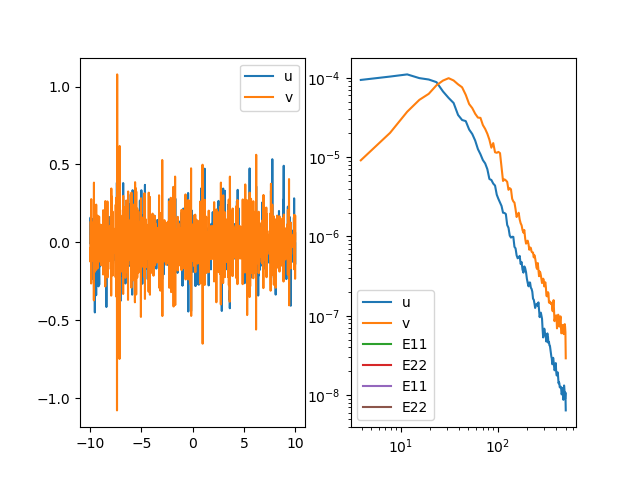

In [105]:
plt.figure(2)
plt.subplot(1,2,1)
plt.plot(t,utot[0],label='u')
plt.plot(t,utot[1],label='v')
plt.legend()
plt.subplot(1,2,2)
(valu,freq) = psd(utot[0],Fs=1/ts,detrend='mean')
(valv,freq) = psd(utot[1],Fs=1/ts,detrend='mean')
plt.loglog(freq[1:],valu[1:],label='u')
plt.loglog(freq[1:],valv[1:],label='v')
#plt.loglog(freq[1:],valu[1:]+valv[1:],label='tot')
plt.legend()

## Find Liepmann spectrum that fits the Guu (E11) best and plot it.

In [107]:
def E11(f,uu,tt):
    return 4*uu*uu*tt/(1+(2*np.pi*f*tt)**2)
def E22(f,uu,tt):
    return 4*uu*uu*tt*(2*(2*np.pi*f*tt)**2)/(1+(2*np.pi*f*tt)**2)**2
from scipy import optimize
opti,_ = optimize.curve_fit(E11,freq[1:],valu[1:],method='lm') # it is probably better to use the log of Guu and of valu here
uuopt,ttopt = opti
plt.loglog(freq[1:],E11(freq[1:],uuopt,ttopt),label='E11')
plt.loglog(freq[1:],E22(freq[1:],uuopt,ttopt),label='E22')
plt.legend()

In [22]:
opti

array([0.13213496, 0.00477935])

In [24]:
#plt.savefig('spectra.pdf')

In [91]:
?optimize.least_squares